In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from IPython.display import display
from torch.utils.data import DataLoader

# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os, shutil
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ships-in-satellite-imagery/shipsnet.json
/kaggle/input/ships-in-satellite-imagery/scenes/scenes/sfbay_3.png
/kaggle/input/ships-in-satellite-imagery/scenes/scenes/lb_2.png
/kaggle/input/ships-in-satellite-imagery/scenes/scenes/lb_3.png
/kaggle/input/ships-in-satellite-imagery/scenes/scenes/sfbay_2.png
/kaggle/input/ships-in-satellite-imagery/scenes/scenes/sfbay_4.png
/kaggle/input/ships-in-satellite-imagery/scenes/scenes/lb_1.png
/kaggle/input/ships-in-satellite-imagery/scenes/scenes/lb_4.png
/kaggle/input/ships-in-satellite-imagery/scenes/scenes/sfbay_1.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170818_180847_1035__-122.35401581365974_37.70687198484906.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170822_181223_0f31__-122.33430439301199_37.75694760192249.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/1__20170129_181027_0e1f__-122.33566224908485_37.75744197248642.png
/kaggle/input/ships-in-satellite-imagery/sh

In [2]:
input_dir = "/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet"

from os import listdir
from os.path import isfile, join

files_ship = [f for f in listdir(input_dir) if int(f[0]) == 1]
files_noship = [f for f in listdir(input_dir) if int(f[0]) == 0]


In [3]:
print(len(files_ship))
print(len(files_noship))

1000
3000


In [4]:
base_dir = "/kaggle/working/storage"
os.mkdir(base_dir) if os.path.isdir(base_dir) == False else print("Dir exists")

ships_dir = "/kaggle/working/storage/ships"
os.mkdir(ships_dir) if os.path.isdir(ships_dir) == False else print("Dir exists")

noships_dir = "/kaggle/working/storage/no_ships"
os.mkdir(noships_dir) if os.path.isdir(noships_dir) == False else print("Dir exists")

train_dir = '/kaggle/working/train'
validation_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

if os.path.isdir(train_dir) == False: 
    os.mkdir(train_dir)
    
else:
    print("Training Dir exists")
    
if os.path.isdir(validation_dir) == False:
    os.mkdir(validation_dir)

else:
    print("Validation Dir exists")
    
if os.path.isdir(test_dir) == False:
    os.mkdir(test_dir)   

else:
    print("Test Dir exists")


In [5]:
train_ships_dir = os.path.join(train_dir, 'ships')
os.mkdir(train_ships_dir) if os.path.isdir(train_ships_dir) == False else print("Dir exists")
validation_ships_dir = os.path.join(validation_dir, 'ships')
os.mkdir(validation_ships_dir) if os.path.isdir(validation_ships_dir) == False else print("Dir exists")
test_ships_dir = os.path.join(test_dir, 'ships')
os.mkdir(test_ships_dir) if os.path.isdir(test_ships_dir) == False else print("Dir exists")

train_noships_dir = os.path.join(train_dir, 'no_ships')
os.mkdir(train_noships_dir) if os.path.isdir(train_noships_dir) == False else print("Dir exists")
validation_noships_dir = os.path.join(validation_dir, 'no_ships')
os.mkdir(validation_noships_dir) if os.path.isdir(validation_noships_dir) == False else print("Dir exists")
test_noships_dir = os.path.join(test_dir, 'no_ships')
os.mkdir(test_noships_dir) if os.path.isdir(test_noships_dir) == False else print("Dir exists")



In [6]:
train_count = 640
for idx in range(train_count):
    src = os.path.join(input_dir, files_ship[idx])
    dst = os.path.join(train_ships_dir, files_ship[idx])
    shutil.copyfile(src, dst)
    
validation_count = 160
for idx in range(train_count, train_count + validation_count):
    src = os.path.join(input_dir, files_ship[idx])
    dst = os.path.join(validation_ships_dir, files_ship[idx])
    shutil.copyfile(src, dst)
    
test_count = 200
for idx in range(train_count + validation_count, train_count + validation_count + test_count):
    src = os.path.join(input_dir, files_ship[idx])
    dst = os.path.join(test_ships_dir, files_ship[idx])
    shutil.copyfile(src, dst)
    
train_count = 2000
for idx in range(train_count):
    src = os.path.join(input_dir, files_noship[idx])
    dst = os.path.join(train_noships_dir, files_noship[idx])
    shutil.copyfile(src, dst)
    
validation_count = 400
for idx in range(train_count, train_count + validation_count):
    src = os.path.join(input_dir, files_noship[idx])
    dst = os.path.join(validation_noships_dir, files_noship[idx])
    shutil.copyfile(src, dst)
    
test_count = 600
for idx in range(train_count + validation_count, train_count + validation_count + test_count):
    src = os.path.join(input_dir, files_noship[idx])
    dst = os.path.join(test_noships_dir, files_noship[idx])
    shutil.copyfile(src, dst)


In [7]:
from torchvision import transforms

train_data_path = "/kaggle/working/train"
val_data_path = "/kaggle/working/validation"
test_data_path = "/kaggle/working/test"

transforms_data = transforms.Compose([transforms.Resize((80, 80)), transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [8]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transforms_data)

val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=transforms_data)

test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transforms_data)


train_data_loader = DataLoader(train_data, batch_size = 20, shuffle = True)
val_data_loader  = DataLoader(val_data, batch_size = 20, shuffle = True)
test_data_loader  = DataLoader(test_data, batch_size=1, shuffle = True)

In [9]:
print(len(train_data_loader))
print(len(val_data_loader))
print(len(test_data_loader))

132
28
800


In [10]:
class CNN_redux(nn.Module):
    def __init__(self, num_classes = 2):
        super(CNN_redux, self).__init__()
        self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=5, padding = 1, bias=True), nn.ReLU(),
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    
                    
                    nn.Conv2d(32, 64, kernel_size=5, padding=1, bias=True), nn.ReLU(),
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    
                    
                    nn.Conv2d(64, 128, kernel_size=5, padding=1, bias=True), nn.ReLU(),
                    nn.BatchNorm2d(128),
                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.classifier = nn.Sequential(
                            nn.Linear(128 * 8 * 8, 1024),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(1024, 256),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(256, 32),
                            nn.ReLU(),
                            nn.Linear(32, 2))

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        
        return x

In [11]:
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [12]:
model = CNN_redux()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 20

In [13]:
model = model.to(device=device)  
PATH = "/kaggle/working/best_model.pth"
class_weights = torch.tensor([0.25, 0.75])
class_weights = class_weights.to(device = device)

if os.path.isfile(PATH) == False:
    for epoch in range(epochs):
        model.train()
        
        correct_training = 0
        correct_validation = 0  
        denom_train = 0
        denom_val = 0
        loss_list = []
        loss_val_list = []
        print("EPOCH: ", epoch + 1)
        for t, (x, y) in enumerate(train_data_loader):

            optimizer.zero_grad()

            x = x.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=torch.long)

            scores = model.forward(x) 

            pred = nn.LogSoftmax(dim = 1)
            predictions = pred(scores)
            predictions = torch.argmax(predictions, axis = 1)

            loss = nn.functional.cross_entropy(scores, y, weight = class_weights)      

            loss.backward()

            optimizer.step()

            correct_training += sum(y == predictions).item()
            denom_train += y.shape[0]
            loss_list.append(loss.item())

        print("Got {}/{} correct".format(correct_training, denom_train))
        print("Training Loss = {:.4f}, Epoch Training Accuracy = {:.4f}\n".format(sum(loss_list) / len(loss_list), 
                                                                       ((correct_training / denom_train) * 100)))

        for t_val, (x_val, y_val) in enumerate(val_data_loader): 

            x_val = x_val.to(device=device, dtype=dtype)  
            y_val = y_val.to(device=device, dtype=torch.long)  

            scores_val = model.forward(x_val)        

            pred_val = nn.LogSoftmax(dim = 1)
            predictions_val = pred_val(scores_val)
            predictions_val = torch.argmax(predictions_val, axis = 1)
            
            loss_val = nn.functional.cross_entropy(scores_val, y_val, weight = class_weights) 
            loss_val_list.append(loss_val.item())
            
            correct_validation += sum(y_val == predictions_val).item()
            denom_val += y_val.shape[0]

        print("Got {}/{} correct".format(correct_validation, denom_val))
        print("Validation Loss = {:.4f}, Epoch Validation Accuracy = {:.4f}\n".format(sum(loss_val_list) / len(loss_val_list), (correct_validation / denom_val) * 100))   
    torch.save(model, PATH)
    print("Training Completed Now.")

else:
    print("Training Completed Already.")

EPOCH:  1
Got 2399/2640 correct
Training Loss = 0.2063, Epoch Training Accuracy = 90.8712

Got 531/560 correct
Validation Loss = 0.0913, Epoch Validation Accuracy = 94.8214

EPOCH:  2
Got 2559/2640 correct
Training Loss = 0.0777, Epoch Training Accuracy = 96.9318

Got 546/560 correct
Validation Loss = 0.0896, Epoch Validation Accuracy = 97.5000

EPOCH:  3
Got 2600/2640 correct
Training Loss = 0.0485, Epoch Training Accuracy = 98.4848

Got 550/560 correct
Validation Loss = 0.0307, Epoch Validation Accuracy = 98.2143

EPOCH:  4
Got 2611/2640 correct
Training Loss = 0.0305, Epoch Training Accuracy = 98.9015

Got 550/560 correct
Validation Loss = 0.0549, Epoch Validation Accuracy = 98.2143

EPOCH:  5
Got 2631/2640 correct
Training Loss = 0.0097, Epoch Training Accuracy = 99.6591

Got 555/560 correct
Validation Loss = 0.0375, Epoch Validation Accuracy = 99.1071

EPOCH:  6
Got 2635/2640 correct
Training Loss = 0.0053, Epoch Training Accuracy = 99.8106

Got 556/560 correct
Validation Loss = 0

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN_redux. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
model = torch.load(PATH)

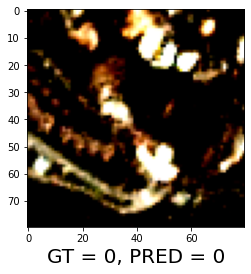

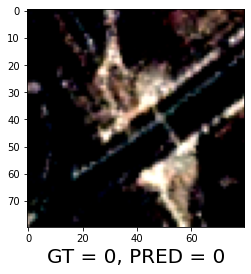

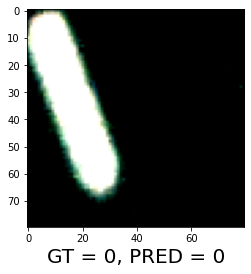

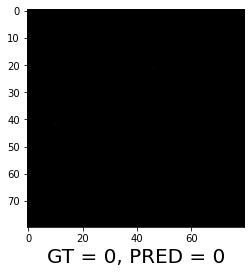

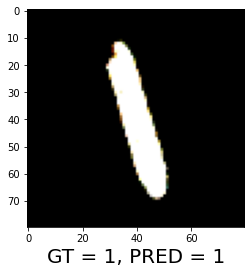

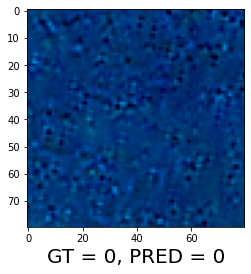

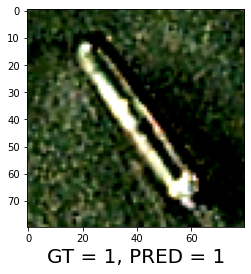

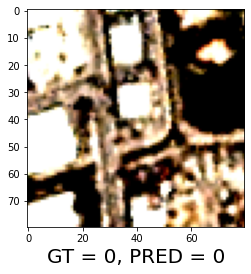

Got 791/800 correct
Test Accuracy = 98.8750



In [15]:
import matplotlib.pyplot as plt
model.eval()
    
correct_test = 0
denom_test = 0

index_list = []
pred_list = []
gt_list = []

for t_test, (x_test, y_test) in enumerate(test_data_loader):
    
    gt_list.append(y_test.item())       
    
    x_test = x_test.to(device=device, dtype=dtype)  
    y_test = y_test.to(device=device, dtype=torch.long)

    scores_test = model.forward(x_test) 

    pred_test = nn.LogSoftmax(dim = 1)
    predictions_test = pred(scores_test)
    predictions_test = torch.argmax(predictions_test, axis = 1)
    
    if (t_test + 1) % 100 == 0:
        plt.imshow(x_test.cpu().numpy().squeeze().transpose(1, 2, 0))
        plt.xlabel("GT = {}, PRED = {}".format(y_test.item(), predictions_test.item()), fontsize = 20)
        plt.show()
        
    
    correct_test += sum(y_test == predictions_test).item()
    denom_test += y_test.shape[0]
    
    pred_list.append(predictions_test.item())
    index_list.append(t_test + 1)
    
    
print("Got {}/{} correct".format(correct_test, denom_test))
print("Test Accuracy = {:.4f}\n".format((correct_test / denom_test) * 100)) 

In [16]:
df = pd.DataFrame({"Index":index_list, "GT":gt_list, "PRED":pred_list})
incorrect = df[df.GT != df.PRED]
display(incorrect)

,Index,GT,PRED
120,121,0,1
257,258,0,1
356,357,0,1
437,438,0,1
502,503,0,1
518,519,0,1
689,690,1,0
728,729,0,1
745,746,0,1


In [17]:
df.to_csv("predictions_ships.csv")